# LLMs Translation Pipeline


This would be a pipeline for Machine Translation from lux to english including data pre-processing, translation and data post-processing.

1. Context information should be included inside each transation sample and sliding windows will be used.
2. Make full use of the model's hallucination properties to make more samples. (Different temperatures: 0.1,0.5,0.9,1.3)
3. Clean the models' output and check the correcteness of the models' output. (Corprus Checking)

## Data pre-processing

In [1]:
import json
import pandas as pd
from utils.utils_nlp import split_paragraph


def load_data(file_path, label):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_data = json.loads(line)
            json_data['label'] = label
            data.append(json_data)
    return data
    
train_data = load_data('data/NC_lux/train.json', 'train')
test_data = load_data('data/NC_lux/test.json', 'test')
dev_data = load_data('data/NC_lux/dev.json', 'dev')
all_data = train_data + test_data + dev_data

NC_lux_df = pd.DataFrame(all_data)

# Take 30% for testing

NC_lux_df = NC_lux_df[0:int(0.3*len(NC_lux_df))]

Drop duplicates

In [2]:
# Drop Duplicates
original_len = len(NC_lux_df)
print("Original length:", original_len)
NC_lux_df.drop_duplicates(subset=['text'], inplace=True)
new_len = len(NC_lux_df)
print("New length after dropping duplicates:", new_len)
dropped_count = original_len - new_len
print("Number of dropped duplicates:", dropped_count)

Original length: 3015
New length after dropping duplicates: 3012
Number of dropped duplicates: 3


Split Sentences Use spacy for sentinizer

!python -m spacy download xx_ent_wiki_sm

In [ ]:
import spacy
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
tqdm.pandas()

def chunk_sentence(sentence, max_embedding, tokenizer):
    sentence_embeddings = tokenizer.encode(sentence)
    chunk_embedding = sentence_embeddings[0:max_embedding]
    chunk_text = tokenizer.decode(chunk_embedding)
    return chunk_text


def extract_sentences(sentencizer, text):
    if "sentencizer" not in sentencizer.pipe_names:
        sentencizer.add_pipe("sentencizer")
    doc = sentencizer(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences


def count_embeddings(tokenizer, sentence):
    tokens = tokenizer.tokenize(sentence)
    return len(tokens)

def split_and_slide(text, max_sentence_window, sentencizer, tokenizer, preference_sentence_windows=None):
    max_embeddings = 256  # Avoid Bigger Embeddings
    min_embeddings = 40    # Avoid Smallest Embeddings
    sentences = extract_sentences(sentencizer, text)
    sub_sentences = []
    windows_size_list = []
    is_chunked_list = []
    for i in range(len(sentences)):
        if preference_sentence_windows:
        # Check if the preferred sentence window meets embedding criteria for the whole text
            current_sentence = ' '.join(sentences[i:i + preference_sentence_windows]).strip()
            embeddings_len = count_embeddings(tokenizer, current_sentence)

            if min_embeddings <= embeddings_len <= max_embeddings:
                sub_sentences.append(current_sentence)
                windows_size_list.append(preference_sentence_windows)
                is_chunked_list.append(False)
                continue

        for window in range(1, max_sentence_window + 1):
            current_sentence = ' '.join(sentences[i:i + window]).strip()
            embeddings_len = count_embeddings(tokenizer,current_sentence)

            if min_embeddings <= embeddings_len <= max_embeddings:
                sub_sentences.append(current_sentence)
                windows_size_list.append(window)
                is_chunked_list.append(False)
                break
            elif embeddings_len > max_embeddings:
                sub_sentences.append(chunk_sentence(current_sentence, max_embedding=max_embeddings, tokenizer=tokenizer).strip())
                windows_size_list.append(window)
                is_chunked_list.append(True)
                break
    return  pd.Series([sub_sentences, windows_size_list, is_chunked_list])


max_length = int(1024 * 0.75) # Max context length * token rate
model_nllb = "facebook/nllb-200-distilled-600M"
model_opus = "Helsinki-NLP/opus-mt-mul-en"

nllb_tokenizer = AutoTokenizer.from_pretrained(model_nllb)
opus_tokenizer = AutoTokenizer.from_pretrained(model_opus)

nllb_model = AutoModelForSeq2SeqLM.from_pretrained(model_nllb,local_files_only=True)
opus_model = AutoModelForSeq2SeqLM.from_pretrained(model_opus,local_files_only=True)

nllb_max_length = nllb_model.config.max_position_embeddings
opus_max_length = opus_model.config.max_position_embeddings

sentencizer = spacy.load('xx_ent_wiki_sm') 

sentence_window = 10 # Needs to be determined
preference_sentence_windows = 3

NC_lux_df[['sub_sentences', 'windows_size',"is_chunked"]] = NC_lux_df['text'].progress_apply(lambda x: split_and_slide(x, sentence_window, sentencizer, nllb_tokenizer, preference_sentence_windows))
NC_lux_df['combined'] = NC_lux_df.apply(
    lambda row: list(zip(row['sub_sentences'], row['windows_size'], row['is_chunked'])), axis=1
)

df_exploded = NC_lux_df.explode('combined')
df_exploded[['sub_sentences', 'windows_size', 'is_chunked']] = pd.DataFrame(df_exploded['combined'].tolist(), index=df_exploded.index)
df_exploded = df_exploded.drop(columns=['combined'])

# df_exploded = df_exploded.rename(columns={'sub_sentences': 'text'})
df_exploded['windows_size'] = df_exploded['windows_size'].astype(int)
df_exploded['sub_sentences'] = df_exploded['sub_sentences'].astype(str)
df_exploded['sub_sentences_len'] =  df_exploded['sub_sentences'].apply(lambda x: count_embeddings(tokenizer=nllb_tokenizer, sentence=x))

/home/lujun_li/anaconda3/envs/causalLLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lujun_li/anaconda3/envs/causalLLM/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
100%|██████████| 3012/3012 [00:32<00:00, 91.48it/s] 


Return the status of of statistic 

In [5]:
windows_size_stats = df_exploded['windows_size'].describe()
windows_size_by_chunk = df_exploded.groupby('is_chunked')['windows_size'].describe()

print("\nWindows Size Stats:\n", windows_size_stats)
print("\nWindows Size Stats by Chunking:\n", windows_size_by_chunk)



Windows Size Stats:
 count    45691.000000
mean         3.026592
std          0.325158
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          8.000000
Name: windows_size, dtype: float64

Windows Size Stats by Chunking:
               count      mean       std  min  25%  50%  75%  max
is_chunked                                                      
False       45567.0  3.030131  0.315708  1.0  3.0  3.0  3.0  8.0
True          124.0  1.725806  0.799784  1.0  1.0  2.0  2.0  5.0


## Start Inference Using the models

In [4]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
source_lang='ltz_Latn'
target_lang='eng_Latn'
device='cuda:0'
batch_size = 2
model_name = "/home/lujun_li/projects/nllb-200-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name,device=device)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


translator = pipeline(
    'translation',
    model=model,
    tokenizer=tokenizer,
    src_lang=source_lang,
    tgt_lang=target_lang,
    max_length=512,
    device=device,
    batch_size = batch_size
)
def translate_text(text, translator):
    output = translator(text)
    translated_text = output[0]['translation_text']
    return translated_text


In [5]:
from transformers.pipelines.pt_utils import KeyDataset

# Example usage
text = " Bei den Dammen a bei den Häre stoung an der Schwäiz de Massestart am Kader vum Tour de Ski um Programm. D'Damme waren op engem Circuit iwwer 10 Kilometer gefuerdert a sou war et d'Linn Svahn aus Schweden, dat sech um Enn am Zilsprint d'Victoire séchere konnt. Op déi zweet Plaz ass d'Julia Stupak aus Russland komm, virun der US-Amerikanerin Jessie Diggins. "
translated_text = translate_text(text,translator)
print(translated_text)


The women's and men's events were held in Switzerland, with the mass start in the Tour de Ski on the programme. The women were challenged on a circuit over 10 kilometres and it was Lin Svahn from Sweden who secured the victory in the final in the goal sprint. In second place came Julia Stupak from Russia, ahead of the American Jessie Diggins.


In [ ]:
from transformers.pipelines.pt_utils import KeyDataset

# Example usage
text = "Bei den Dammen a bei den Häre stoung an der Schwäiz de Massestart am Kader vum Tour de Ski um Programm. D'Damme waren op engem Circuit iwwer 10 Kilometer gefuerdert a sou war et d'Linn Svahn aus Schweden, dat sech um Enn am Zilsprint d'Victoire séchere konnt. Op déi zweet Plaz ass d'Julia Stupak aus Russland komm, virun der US-Amerikanerin Jessie Diggins."
translated_text = translate_text(text,translator)
print(translated_text)

output = []
texts = df_exploded["sub_sentences"][0:4].to_list()

for i in tqdm(range(0, len(texts), batch_size), desc="Translating", unit="batch"):
    batch = texts[i:i+batch_size]
    translated_batch = translator(batch)
    output.extend(translated_batch)

In [51]:
test = df_exploded[0:4]
translated_texts = [item['translation_text'] for item in output]
test["translated_sub_sentences"]= translated_texts

/tmp/ipykernel_173784/1496423853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["translated_sub_sentences"]= translated_texts


In [52]:
test

,label,text,sub_sentences,windows_size,is_chunked,sub_sentences_len,translated_sub_sentences
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Bei den Dammen a bei den Häre stoung an der Sc...,3.0,False,106,The women and the women were the masses in Swi...
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,D'Damme waren op engem Circuit iwwer 10 Kilome...,3.0,False,103,The ladies were competing on a circuit of over...
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Op déi zweet Plaz ass d'Julia Stupak aus Russl...,3.0,False,108,In the second place came Julia Stupak from Rus...
0,train,Bei den Dammen a bei den Häre stoung an der Sc...,Am General steet d'Linn Svahn mat engem Virspr...,3.0,False,109,"In general, Line Svahn is the top with a lead ..."


In [36]:
len(translated_texts)

20

In [32]:
test

0                           Bei den Dammen a bei den Häre stoung an der Sc...
0                           D'Damme waren op engem Circuit iwwer 10 Kilome...
0                           Op déi zweet Plaz ass d'Julia Stupak aus Russl...
0                           Am General steet d'Linn Svahn mat engem Virspr...
0                           Spéider sinn dann d'Hären iwwer 15 Kilometer u...
                                                  ...                        
9                           An enger klenger Schossel, de Rum, 2 Iessläffe...
9                           Domat de Stollen an de Glieser beträufelen. An...
9                           An enger Schossel de Joghurt, d´Sauer Ram, de ...
9                           D´Crème an all Glas iwwert de Stollen verdeele...
translated_sub_sentences    [The women and the women were the masses in Sw...
Name: sub_sentences, Length: 201, dtype: object

In [18]:
import pandas as pd

json_data = translated_df.to_json(orient='records', lines=True)

with open('translated_data.json', 'w') as f:
    f.write(json_data)

In [ ]:
def calculate_tokens(text, tokenizer):
    if isinstance(text, str):
        tokens = tokenizer.tokenize(text)
        tokens_len = len(tokens)
        return pd.Series([tokens, tokens_len])

df_exploded[['tokens', 'tokens_length']] = df_exploded['sub_sentences'].progress_apply(lambda x: calculate_tokens(x, nllb_tokenizer))


100%|██████████| 48636/48636 [00:09<00:00, 4917.41it/s]


In [46]:
text = """Hello, nihao. nihao. 
What is the problems.


Fuck you; I am your daddy."""

In [47]:
sentences = re.split(r'(?<=[.!?;…])+', text)
cleaned_sentences = [re.sub(r'^[\W_ ]+|[\W_ ]+$', '', sentence) for sentence in sentences]
cleaned_sentences


['Hello, nihao',
 'nihao',
 'What is the problems',
 'Fuck you',
 'I am your daddy',
 '']

In [56]:
test = df_exploded[df_exploded["length"] == df_exploded["length"].max()]

In [57]:
test

,label,length,text
9,train,768,"E puer Blueberries driwwer streeën, nach e bës..."
26,train,768,"D'Resultat muss iwwerdeems op Lëtzebuergesch, ..."
26,train,768,"Par conséquent, toute personne, âgée de 12 ans..."
40,train,768,Den Depistage leeft ewell zanter bal 3 Méint a...
49,train,768,La priorité absolue de la réglementation de ce...
...,...,...,...
10038,dev,768,Fanny Kinsch Reaktioun vun der DPOch fir den D...
10038,dev,768,er mat gefreet...Déi gréng Parteipresidentin D...
10038,dev,768,"Et wier kloer, datt d'Klimafro an Europa ganz ..."
10051,dev,768,XR.Cet événement spécial prendra place au sein...


In [31]:
max_row = df_exploded[df_exploded['length'] == df_exploded['length'].max()]

In [33]:
max_row

,label,length,text
9,train,768,"E puer Blueberries driwwer streeën, nach e bës..."
26,train,768,"D'Resultat muss iwwerdeems op Lëtzebuergesch, ..."
26,train,768,"Par conséquent, toute personne, âgée de 12 ans..."
40,train,768,Den Depistage leeft ewell zanter bal 3 Méint a...
49,train,768,La priorité absolue de la réglementation de ce...
...,...,...,...
10038,dev,768,Fanny Kinsch Reaktioun vun der DPOch fir den D...
10038,dev,768,er mat gefreet...Déi gréng Parteipresidentin D...
10038,dev,768,"Et wier kloer, datt d'Klimafro an Europa ganz ..."
10051,dev,768,XR.Cet événement spécial prendra place au sein...


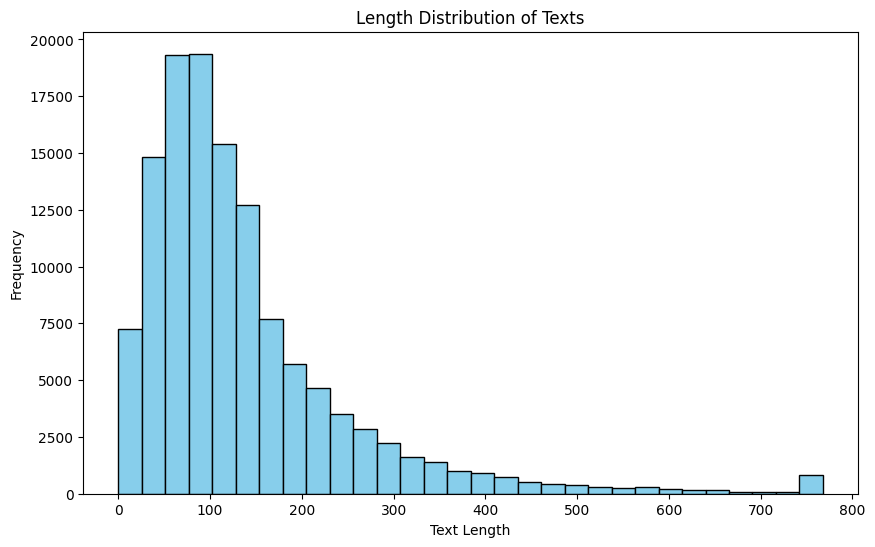

In [10]:
import matplotlib.pyplot as plt

df_exploded["length"] = df_exploded["text"].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df_exploded["length"], bins=30, color='skyblue', edgecolor='black')
plt.title("Length Distribution of Texts")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# Inference Modeling


|  Models |  Luxembourgish to English |  Luxembourgish to French | Luxembourgish to  German |
|:-------:|:-------:|:-------:|:-------:|
|  Mixtral 8*22B  |  Yes  |  Yes  |  Yes  |
|  Llama-3-4B  |  Yes  |  Yes  |  Yes  |
|  ChatGPT 3.5-Turbo |  Yes  |  Yes  |  Yes  |

In [ ]:
prompt_template = """Please translate the following {language_1} text into {language_2}. Please answer me with only translated text!

---------------------------------- Text to be translated ----------------------------------

{Text}

---------------------------------- Text to be translated ----------------------------------

"""

df_exploded["prompt"] = df_exploded["text"].apply( lambda text: prompt_template.format(language_1="Luxembourgish", language_2="English", Text=text))

In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    pipeline,
)
from tqdm import tqdm
import pandas as pd
import argparse
import torch
import numpy as np
from datetime import datetime
import time

def initialize_pipeline(model_config_dict):
    model_path = model_config_dict["CURRENT_RUNNING_MODEL"]
    if not model_path:
        raise ValueError("CURRENT_RUNNING_MODEL is not set")
    load_in_4bit,load_in_8bit = model_config_dict["CURRENT_LOAD_IN_4BIT"],model_config_dict["CURRENT_LOAD_IN_8BIT"]

    if model_config_dict["IF_LOADING_QUANTIZATION"]:
        nf4_config = BitsAndBytesConfig(load_in_4bit=load_in_4bit, load_in_8bit=load_in_8bit,bnb_4bit_compute_dtype=torch.float16,)
    else:
        nf4_config = None

    generation_config = GenerationConfig.from_pretrained(model_path)
    # Sampling Methods Configuration
    generation_config.do_sample = True
    generation_config.max_length = 1024
    generation_config.pad_token_id = 0
    generation_config.top_p = 0.9
    generation_config.temperature = 0.9
    generation_config.max_new_tokens = 512
    dynamic_text_pipeline = pipeline("text-generation", model=model_path, torch_dtype=torch.float32, device_map="auto")
    dynamic_text_pipeline.model.generation_config = generation_config
    return dynamic_text_pipeline

def generate_text(pipeline, prompt):
    messages = [
        {"role": "system", "content": ""},
        {"role": "user", "content": prompt},
    ]
    response = pipeline(prompt)[0]["generated_text"][-1]
    return response


model_config_dict = {
    "CURRENT_RUNNING_MODEL": "mt_luxembourgish/meta-llama/Llama-3.2-3B-Instruct",
    "IF_LOADING_QUANTIZATION": False,
    "CURRENT_LOAD_IN_4BIT": False,
    "CURRENT_LOAD_IN_8BIT": False
}
pipeline = initialize_pipeline(model_config_dict)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Run inference
from datetime import datetime


pbar = tqdm(total=len(df_exploded))
pbar.n = 0; pbar.last_print_n =0, pbar.refresh()

current_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
for index, row in df_exploded.iterrows():
        updated_row = row.copy()
        updated_row["generated_response"] = generate_text(pipeline=pipeline, prompt=updated_row["prompt"])
        updated_dataframe = pd.DataFrame([updated_row])
        if times == 0:
            updated_dataframe.to_csv( f"results/translation_{current_time}", index=False, mode="w", header=True)
        else:
            updated_dataframe.to_csv( f"results/translation_{current_time}", index=False, mode="a", header=False)
        pbar.update(1)
        times = times + 1